In [1]:
from policy_net.environment import Environment
from policy_net.learning_agent import LearningAgent
from policy_net.animate import animate_species_ownership_with_static_layers
from policy_net.game import play_game, finish_episode
from policy_net.policy_net import PolicyNet
from nca.constsants import CHANNELS, H, W, NUM_CHANNELS
from nca.nca_model import NCA, get_species_features_tensor,build_channel_mapping_from_species_list
from nca.generate_map import generate_training_world
import torch
import random

from collections import Counter, defaultdict


16NUMCHANNELS


In [2]:
torch.cuda.is_available()

True

In [2]:
# Setup

device = 'cuda' if torch.cuda.is_available() else 'cpu' #cuda



policy0 = PolicyNet(num_species=5, h=H, w=W).to(device)
policy1 = PolicyNet(num_species=5, h=H, w=W).to(device)


agent_0_mask = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float32)
agent_1_mask = 1.0 - agent_0_mask

agent0 = LearningAgent(agent_id=0, policy_net=policy0,  start_quadrant="top_left", agent_mask=agent_0_mask)
agent1 = LearningAgent(agent_id=1, policy_net=policy1,  start_quadrant="bottom_right", agent_mask=agent_1_mask)
agents = [agent0, agent1]

optimizer0 = torch.optim.Adam(policy0.parameters(), lr=1e-3)
optimizer1 = torch.optim.Adam(policy1.parameters(), lr=1e-3)
optimizers = [optimizer0, optimizer1]


plant_list = agents[0].available_species + agents[1].available_species
# CHANNELS["plants"] = {
#     plant_name: 6 + i
#     for i, plant_name in enumerate(plant_list)
# }
CHANNELS["plants"] = [
    (plant_name, 6 + i)
    for i, plant_name in enumerate(plant_list)
]
sample_species_features = get_species_features_tensor()

model = NCA(NUM_CHANNELS, sample_species_features.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load("nca.pth",map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()


agent_logs = {
    agent.agent_id: defaultdict(list) for agent in agents
}


In [ ]:

import math
from collections import Counter, defaultdict
import numpy as np
from itertools import combinations

def compute_entropy(actions):
    if not actions:
        return 0.0
    counter = Counter(actions)
    total = sum(counter.values())
    return -sum((count / total) * math.log2(count / total) for count in counter.values())

torch.autograd.set_detect_anomaly(True)

for episode in range(200):
    print(episode)
    grid = generate_training_world(H, W, seed_plants=False).to(device)
    ownership_grid = torch.full((1, H, W), fill_value=-1, dtype=torch.long, device=device)
    elevation_static = grid[:, CHANNELS["elevation"]].clone().detach()
    shade_static = grid[:, CHANNELS["shade"]].clone().detach()
    soil_static = {
        idx: grid[:, idx].clone().detach()
        for idx in CHANNELS["soil"].values()
    }
    for agent in agents:
        agent.randomize_species(5)
        agent.species_used = []
        agent.row_used = []
        agent.column_used = []
        
    if random.random() < .5:
        print("Agent 0 is player 1, Agent 1 is player 2")
        agents[0].start_quadrant = "top_left"
        agents[0].player_number = 1
        agents[1].start_quadrant = "bottom_right"
        agents[1].player_number = 2
        species_list = agents[0].available_species + agents[1].available_species
    else:
        print("Agent 1 is player 1, Agent 0 is player 2")
        agents[1].start_quadrant = "top_left"
        agents[1].player_number = 1
        agents[0].start_quadrant = "bottom_right"
        agents[0].player_number = 2
        species_list = agents[1].available_species + agents[0].available_species

    species_features = get_species_features_tensor(species_list=species_list)
    build_channel_mapping_from_species_list(species_list)   
    env = Environment(grid, model, ownership_grid, agents, elevation_static, soil_static, shade_static, species_features, species_list, steps_per_turn=5)
    
    game_rounds = 2
    if (agents[0].training_stage > 2):
        game_rounds = 2 * agents[0].training_stage
    env.steps_per_turn = int(60 / game_rounds)



    scores, actions = play_game(env, species_features, game_rounds ,False)
    def compute_agent_diversity_loss(actions, agent_id):

        # Filter to only actions taken by this agent
        filtered = [a for a in actions if a[0][0] == agent_id]
        if len(filtered) <= 1:
            return 0.0  # No diversity penalty for 0 or 1 action

        # Flatten to 1D vectors (excluding agent id)
        vecs = [np.array(a[0][1:] + a[1][1:]) for a in filtered]

        total_similarity = 0.0
        count = 0

        for v1, v2 in combinations(vecs, 2):
            dist = np.linalg.norm(v1 - v2)
            similarity = np.exp(-dist)  # similarity close to 1 if very similar
            total_similarity += similarity
            count += 1

        return total_similarity / count
    print(scores)
    for agent in agents: 

        diversity = compute_agent_diversity_loss(actions, agent.agent_id)
        # # Compute diversity reward based on action entropy
        # entropy = compute_entropy(agent_actions)
        # diversity_bonus = entropy * 5  # Scale as needed
        diversity_bonus = len(agent.species_used) * 400
        #agent.diversity_reward = diversity_bonus
        
        reward = scores[agent.agent_id]
        # if (agent.training_stage >= 3):
        #     agent.rewards[-1] += (1 - diversity) * 1000
        if (agent.training_stage >= 5 or agent.training_stage == 0):   
            agent.apply_game_end_reward(reward)
            #agent.rewards[-1] += (reward) * 20
  
        agent.check_curriculum()

        log = agent_logs[agent.agent_id]
        log["episode"].append(episode)
        log["quadrant_penalty"].append(agent.quadrant_penalty)
        log["species_penalty"].append(agent.species_penalty)
        try:
            log["suitability_reward"].append(agent.suitability_reward.cpu().item())
        except:
            log["suitability_reward"].append(agent.suitability_reward)
        log["diversity_reward"].append(agent.diversity_reward)
        log["score"].append(reward)
        log["training_stage"].append(agent.training_stage)
        agent.log_and_reset_loss()
        

    grid.detach()
    for i in range(len(agents)):
        finish_episode(agents[i], optimizers[i], grid)
        

0
Agent 0 is player 1, Agent 1 is player 2
[(0, 3, 38, 14), (1, 5, 34, 2)]
[(0, 6, 42, 6), (1, 6, 46, 6)]
{0: 6.0, 1: 3.0}
Agent 0 Stage 0 Growth: 120 Quad Pen: 0 Species Pen: -1000  Suit Rew: 400 Diversity  Rew 0
Agent 1 Stage 0 Growth: 60 Quad Pen: 0 Species Pen: 0  Suit Rew: 400 Diversity  Rew 200
1
Agent 1 is player 1, Agent 0 is player 2
[(0, 5, 54, 18), (1, 2, 18, 6)]
[(0, 8, 42, 50), (1, 6, 62, 38)]
{0: 3.0, 1: 348.0}
Agent 0 Stage 0 Growth: 60 Quad Pen: 0 Species Pen: 0  Suit Rew: 222 Diversity  Rew 200
Agent 1 Stage 0 Growth: 6960 Quad Pen: 0 Species Pen: -1000  Suit Rew: 400 Diversity  Rew 0
2
Agent 1 is player 1, Agent 0 is player 2
[(0, 9, 10, 54), (1, 1, 22, 18)]
[(0, 3, 26, 6), (1, 3, 42, 26)]
{0: 43.0, 1: 126.0}
Agent 0 Stage 0 Growth: 860 Quad Pen: 0 Species Pen: -1000  Suit Rew: 270 Diversity  Rew 0
Agent 1 Stage 0 Growth: 2520 Quad Pen: 0 Species Pen: 0  Suit Rew: 0 Diversity  Rew 200
3
Agent 0 is player 1, Agent 1 is player 2
[(0, 6, 26, 18), (1, 2, 38, 42)]
[(0, 1, 

KeyboardInterrupt: 

In [ ]:
grid = generate_training_world(H, W, seed_plants=False).to(device)
ownership_grid = torch.full((1, H, W), fill_value=-1, dtype=torch.long, device=device)
elevation_static = grid[:, CHANNELS["elevation"]].clone().detach()
shade_static = grid[:, CHANNELS["shade"]].clone().detach()

soil_static = {
    idx: grid[:, idx].clone().detach()
    for idx in CHANNELS["soil"].values()
}

agent0Species = ["grass_0", "shrub_0", "tree_0", "grass_1","shrub_2"]
agent1Species = ["grass_1", "shrub_1", "tree_1", "grass_2","tree_2"]

agent0 = LearningAgent(agent_id=0, policy_net=policy0, available_species=agent0Species, start_quadrant="top_left", agent_mask=agent_0_mask)
agent1 = LearningAgent(agent_id=1, policy_net=policy1, available_species=agent1Species, start_quadrant="bottom_right", agent_mask=agent_1_mask)
agents = [agent0, agent1]

agents[0].player_number = 1
agents[1].player_number = 2


species_list = agents[0].available_species + agents[1].available_species
species_features = get_species_features_tensor(species_list=species_list)   
build_channel_mapping_from_species_list(species_list)   
print(species_features.shape)

env = Environment(grid, model, ownership_grid, agents, elevation_static, soil_static, shade_static, species_features, species_list, steps_per_turn=5)


scores = play_game(env, species_features, max_turns=15)
print(scores)
ani = animate_species_ownership_with_static_layers(env, elevation_static, soil_static)
from IPython.display import HTML
HTML(ani.to_jshtml())


torch.Size([10, 17])
[(0, 2, 26, 2), (1, 7, 38, 34)]
[(0, 0, 30, 2), (1, 8, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 5, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 8, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 3, 26, 2), (1, 6, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 5, 38, 34)]
[(0, 0, 30, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
[(0, 0, 26, 2), (1, 5, 38, 34)]
[(0, 0, 26, 2), (1, 7, 38, 34)]
({0: 415.0, 1: 96.0}, [[(0, 2, 26, 2), (1, 7, 38, 34)], [(0, 0, 30, 2), (1, 8, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 5, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 8, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 3, 26, 2), (1, 6, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 5, 38, 34)], [(0, 0, 30, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 7, 38, 34)], [(0, 0, 26, 2), (1, 5, 38, 34)], [(0, 0, 26, 2)

In [5]:

# After training loop, or at a checkpoint
torch.save({
    'model_state_dict': policy1.state_dict(),
    'optimizer_state_dict': optimizer1.state_dict()
}, "policy_net.pth")

In [37]:
log["suitability_reward"].append(0)
log["diversity_reward"].append(0)
log["score"].append(0)
log["training_stage"].append(4)

In [4]:
import torch

# Set model to evaluation mode
model = PolicyNet(5, H, W)
checkpoint = torch.load("policy_net.pth", map_location="cpu")  # Force loading on CPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # ← disables dropout, noise, etc.


PolicyNet(
  (conv1): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (location_head): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=(16, 16), stride=(16, 16), padding=0)
  (env_proj): Linear(in_features=32, out_features=64, bias=True)
  (species_proj): Linear(in_features=17, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
import torch

# Set model to evaluation mode
model = PolicyNet(3, H, W)
checkpoint = torch.load("policy_net.pth", map_location="cpu")  # Force loading on CPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # ← disables dropout, noise, etc.

# Sample input matching model expectations
dummy_input = torch.zeros(1, NUM_CHANNELS + 1, H, W)

torch.onnx.export(
    model,
    dummy_input,
    "policy_net.onnx",
    input_names=["input"],
    output_names=["x1", "x2", "x3", "x4", "species_logits", "location_logits"],
    opset_version=13,
    do_constant_folding=False
)



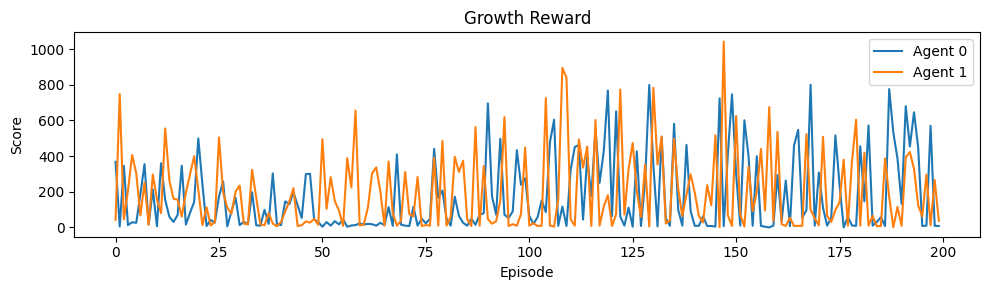

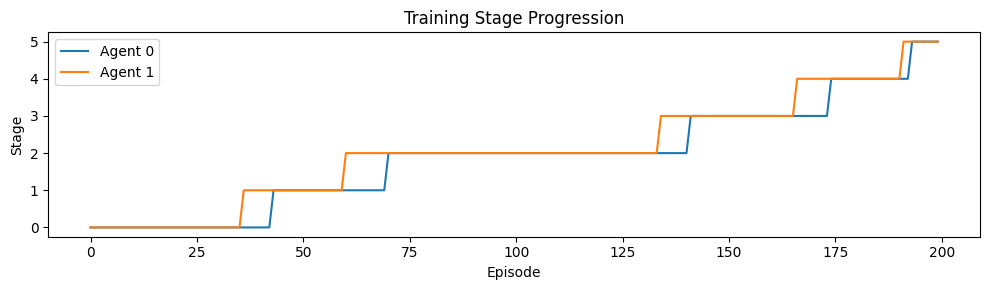

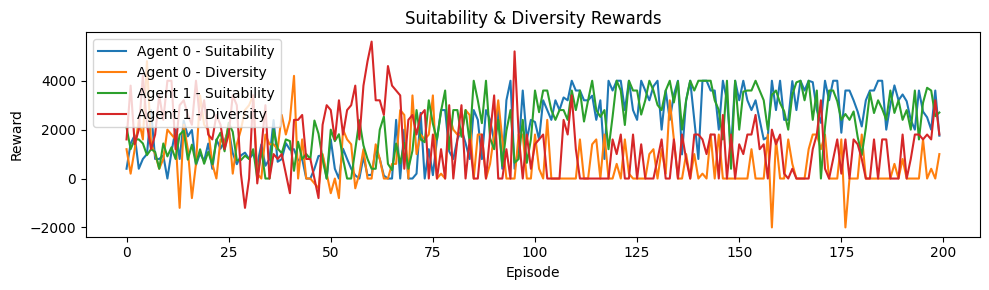

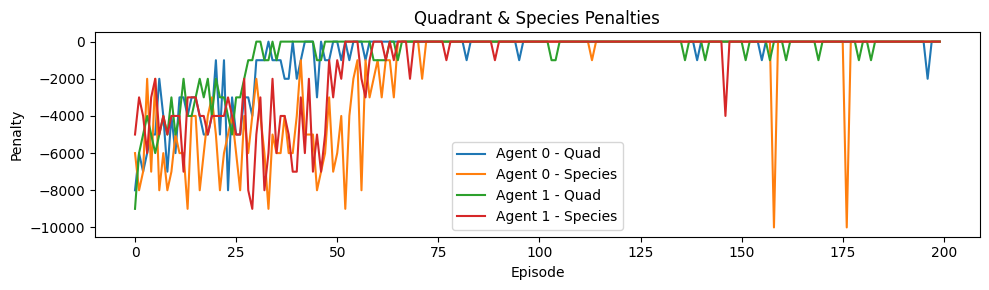

In [5]:
plot_agent_metrics(agent_logs)

In [ ]:
import matplotlib.pyplot as plt

def plot_agent_metrics(agent_logs):
    episodes = list(next(iter(agent_logs.values()))["episode"])  # Assumes both agents share episode indices

    # --- Plot 1: Growth Reward (Score) ---
    plt.figure(figsize=(10, 3))
    plt.title("Growth Reward")
    for agent_id, log in agent_logs.items():
        plt.plot(episodes, log["score"], label=f"Agent {agent_id}")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Training Stage ---
    plt.figure(figsize=(10, 3))
    plt.title("Training Stage Progression")
    for agent_id, log in agent_logs.items():
        plt.plot(episodes, log["training_stage"], label=f"Agent {agent_id}")
    plt.xlabel("Episode")
    plt.ylabel("Stage")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Rewards ---
    plt.figure(figsize=(10, 3))
    plt.title("Suitability & Diversity Rewards")
    for agent_id, log in agent_logs.items():
        plt.plot(episodes, log["suitability_reward"], label=f"Agent {agent_id} - Suitability")
        plt.plot(episodes, log["diversity_reward"], label=f"Agent {agent_id} - Diversity")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Penalties ---
    plt.figure(figsize=(10, 3))
    plt.title("Quadrant & Species Penalties")
    for agent_id, log in agent_logs.items():
        plt.plot(episodes, log["quadrant_penalty"], label=f"Agent {agent_id} - Quad")
        plt.plot(episodes, log["species_penalty"], label=f"Agent {agent_id} - Species")
        plt.plot(episodes, log["redunancy_penalty"], label=f"Agent {agent_id} - Redundancy")
    plt.xlabel("Episode")
    plt.ylabel("Penalty")
    plt.legend()
    plt.tight_layout()
    plt.show()
